# **Analyzing Customer Churn for a Telecom Company**

## **Table of Contents**

* [Introduction](#introduction)
* [Exploratory Data Analysis](#exploration-data-analysis)
* [Data Cleaning](#data-cleaning)
* [Feature Selection](#feature-selection)
* [Feature Engineering](#feature-engineering)
* [Modeling](#modeling)
* [Conclusion](#conclusion)

#### **Objective**

This project focuses on churn analysis for a telecom company. We will explore data-driven techniques to reveal the hidden patterns behind customer churn. Our goal is not only to predict when customers are likely to leave, but also to uncover the key factors influencing their decisions.

#### **The dataset**

This dataset, obtained from Kaggle, includes the following variables:
* **Customer profile information** (customerID, gender, etc.) 
* **Services provided to the customer** (InternetService, OnlineSecurity, StreamingTV, etc.)
* **Subscription information** (nature of the contract, payment method, monthly charges, etc.)
* **Churn state** (a variable that tells if a defined customer churned or not)

For a more detailed description of the dataset, you can click on the following link : [Telco Customer Churn
](https://www.kaggle.com/datasets/blastchar/telco-customer-churn)

<a id="introduction"></a>

## **1. Introduction**

### **1.1. Import the required libraries**

In [1]:
# Data Analysis libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns

# Preprocessing libraries
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OrdinalEncoder

# Modeling libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, ConfusionMatrixDisplay

### **1.2. Load the data**

In [2]:
churn_df = pd.read_csv("../data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
churn_df.head().T

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


In [3]:
churn_df.shape

(7043, 21)

There are 7043 instances with 21 attributes in the dataset. Each instance represents the state of a specific client.

Let's get a quick description of the data.

In [4]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


On the 21 attributes, there are 3 numerical (int / float) attributes and 18 categorical (object) attributes. Based on Kaggle’s variable descriptions, the data types seem largely correct, with a few exceptions:

* The **TotalCharges** attribute should be numeric because it is about amounts of money. The fact it has object type suppose there are some strings in its column.
* Although the **SeniorCitizen** attribute is numeric but binary. Arithmetic operations (additions, divisions, etc.) are not valid for this kind of variables. Then, it will be used as a categorical attribute later.

By looking at the non-null count, it can also be noticed that there are no missing values in the dataset.

<a id="exploration-data-analysis"></a>

## **2. Exploratory Data Analysis**

Before going to the analysis, data should be splitted into train and test. Test set must be always be separated of the training to avoid *data snooping bias* (contamination of data). But as there is not enough data, splitting will be done later.

Let's convert the two problematic columns detected earlier to appropriate types to make the exploration phase easy.

**Conversion of the variable TotalCharges to float type**

In [5]:
num_list, str_list = [], []
for value in churn_df["TotalCharges"]:
    try:
        num_value = float(value)
        num_list.append(num_value)
    except:
        # Objects detected are replaced by None
        num_list.append(None)
        str_list.append(value)

churn_df["TotalCharges"] = pd.Series(num_list)

In [6]:
str_list

[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']

All the object values detected in this column are spaces. Let's do a quick investigation of the samples with TotalCharges equal to None.

In [7]:
churn_df[churn_df["TotalCharges"].isna()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


If we pay close attention to the data that has emerged, we can see that only customers who have not yet been with the supplier for a year have a total charge equal to None.

In [8]:
tc = churn_df[churn_df["TotalCharges"].isna()]
te = churn_df[churn_df["tenure"] == 0]

tc.equals(te)

True

The verification proves our initial hypothesis. These values will be treated in a rather special way later on.

**Conversion of the variable SeniorCitizen to object type**

In [9]:
churn_df["SeniorCitizen"] = churn_df["SeniorCitizen"].astype(str)

In [10]:
churn_df["SeniorCitizen"].dtype == "object"

True

**Identification of numerical and categorical variables**

Let's begin by removing the customerID column from the dataframe because it is not useful for our analysis. Note that, if the goal is to do a kind of clustering to identify customerID that are more likely to churn, it will be useful to keep this attribute.

In [11]:
churn_df = churn_df.drop(columns=["customerID"])

In [12]:
churn_df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

Then, we will assign each variable to the appropriate list according its type.

In [13]:
numerical_cols = [col for col in churn_df.columns if churn_df[col].dtype in ["int", "float"]]
numerical_cols

['tenure', 'MonthlyCharges', 'TotalCharges']

There are 3 numerical columns.

In [14]:
# We exclude Churn column here because it is our target
categorical_cols = [col for col in churn_df.columns if churn_df[col].dtype == "object" and col != "Churn"]
categorical_cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

There are 16 categorical columns.

In [15]:
target_col = ["Churn"]

Let's begin the exploration !

### **2.1. Univariate Analysis**

#### **2.1.1. Distribution of the target variable (Churn)**

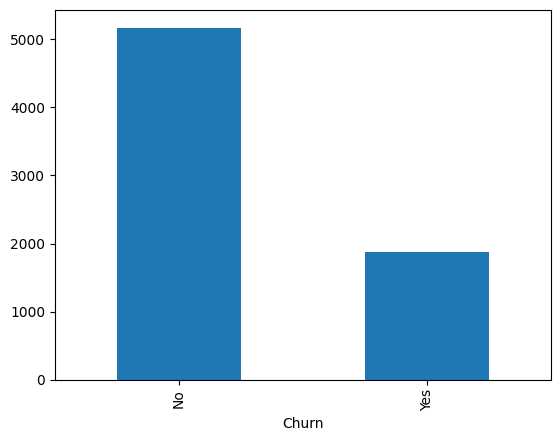

In [16]:
churn_df[target_col[0]].value_counts().plot(kind="bar")
plt.show()

The target variable *Churn* is imbalanced. In the dataset, the number of customers who did not churn is nearly three times higher than those who did. This could initially suggest effective customer management by the company, or simply a limited representation of churn cases in the data.

#### **2.1.2. Distributions of numerical variables**

In [17]:
churn_df[numerical_cols].describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7032.000000
mean,32.371149,64.761692,2283.300441
std,24.559481,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3794.737500
max,72.000000,118.750000,8684.800000


Looking at these statistics, we notice a few things:
* The count of TotalCharges is now 7032. The replacements that are done earlier are the reasons behind that.
* The monthly charges ranges from 18.25 to 118.75.
* The median tenure at the Telecom company is 29 months (2 years and 5 months).

Let's take a look at the distributions of these variables.

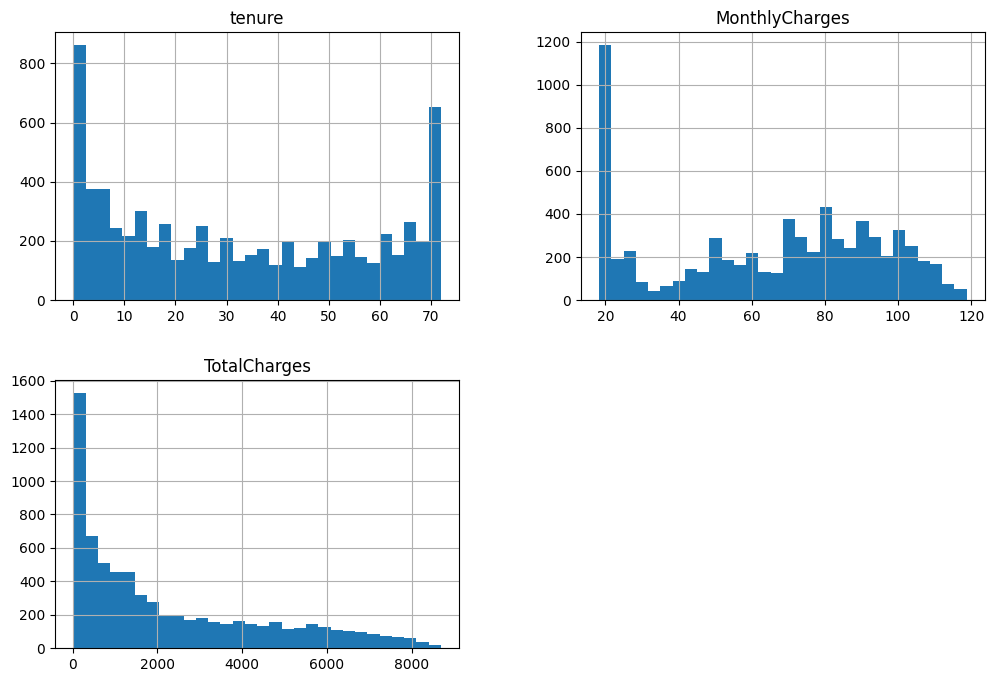

In [18]:
churn_df[numerical_cols].hist(bins=30, figsize=(12, 8))
plt.show()

None of the distributions is normal. In the case of TotalCharges variable, there is a **right-skewed** distribution. If we look at the tenure variable, we can also see that there is a significant proportion of customers at the beginning of their contract (0 months) and at the end of their contract (more than 70 months).

#### **2.1.3. Distributions of categorical variables**

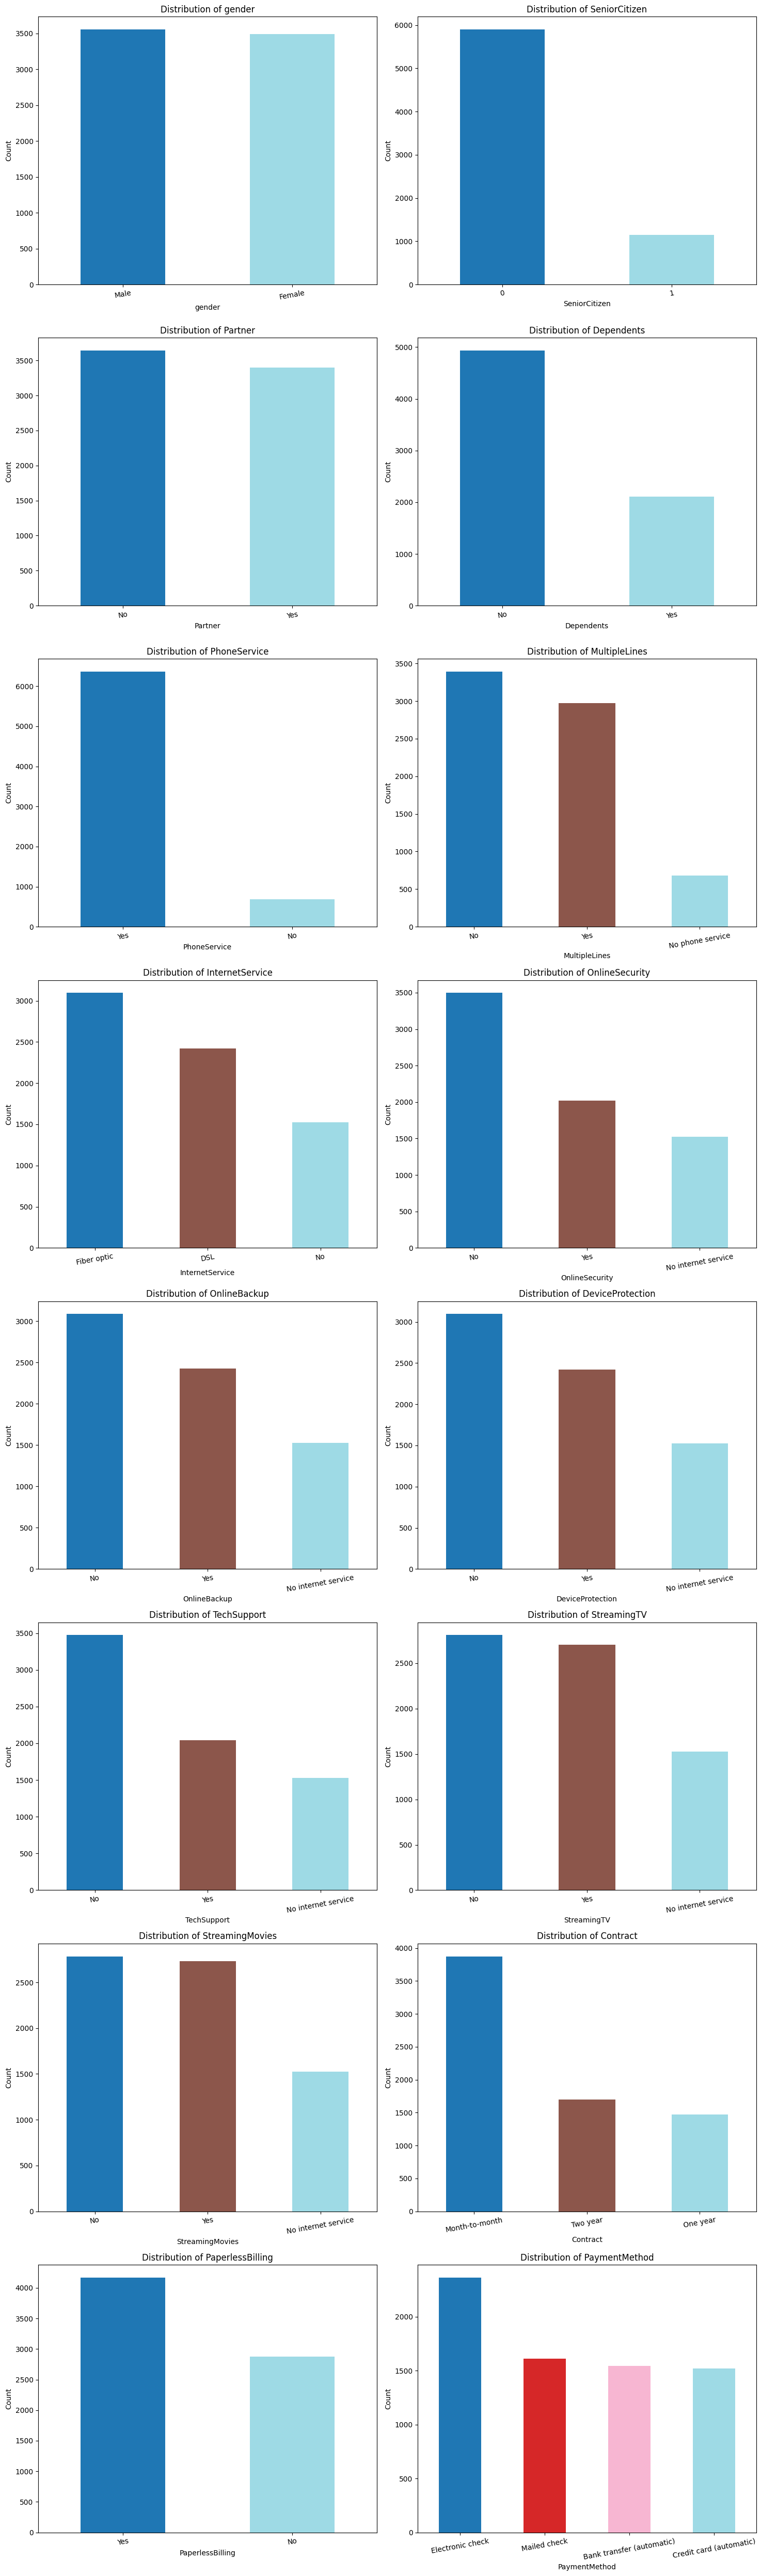

In [19]:
n_rows, n_cols = 8, 2  # 2 x 8 = 16

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 50))
axes = axes.flatten()  # For easy iteration

for i, col in enumerate(categorical_cols):
    value_counts = churn_df[col].value_counts()
    # Generate a list of colors (one per bar)
    colors = cm.tab20(np.linspace(0, 1, len(value_counts)))

    value_counts.plot(kind="bar", ax=axes[i], color=colors)
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_ylabel("Count")
    axes[i].set_xlabel(col)
    axes[i].tick_params(axis="x", rotation=10)

plt.tight_layout()
plt.show()


Some observations :

* Each of the categorical variables have between 2 and 4 classes.
* There are *as many men as women* in the dataset. Similarly, there are *as many people who are married as those who are not*.
* Customers with dependents are more numerous (more than twice as many) than those without.
* There are *very few senior citizen* in the dataset.
* Almost all customers have phone service.
* Phone service and internet service are linked to other services provided by the company. *Correlations* are possible for those services.
* Customers generally prefer Month-to-month contract.
* Regarding contracts, customers show a clear preference for electronic invoices over paper ones. Electronic check is also the most commonly used payment method for billing.

### **2.2. Bivariate and Multivariate Analysis**

Based on the previous observations, let's formulate some hypotheses before doing the multivariate analysis. If we put ourselves in the shoes of an average customer of a telephone operator, we could assume that there are two main reasons behind churn:
* Poor quality of the various services.
* Slightly high prices for services.

Bivariate and multivariate analyses will therefore focus on these factors, but also on the correlations between the different services.

#### **2.2.1. Analysis of repartitions**

We will start by looking at the repartition of the Churn in the categorical variables.

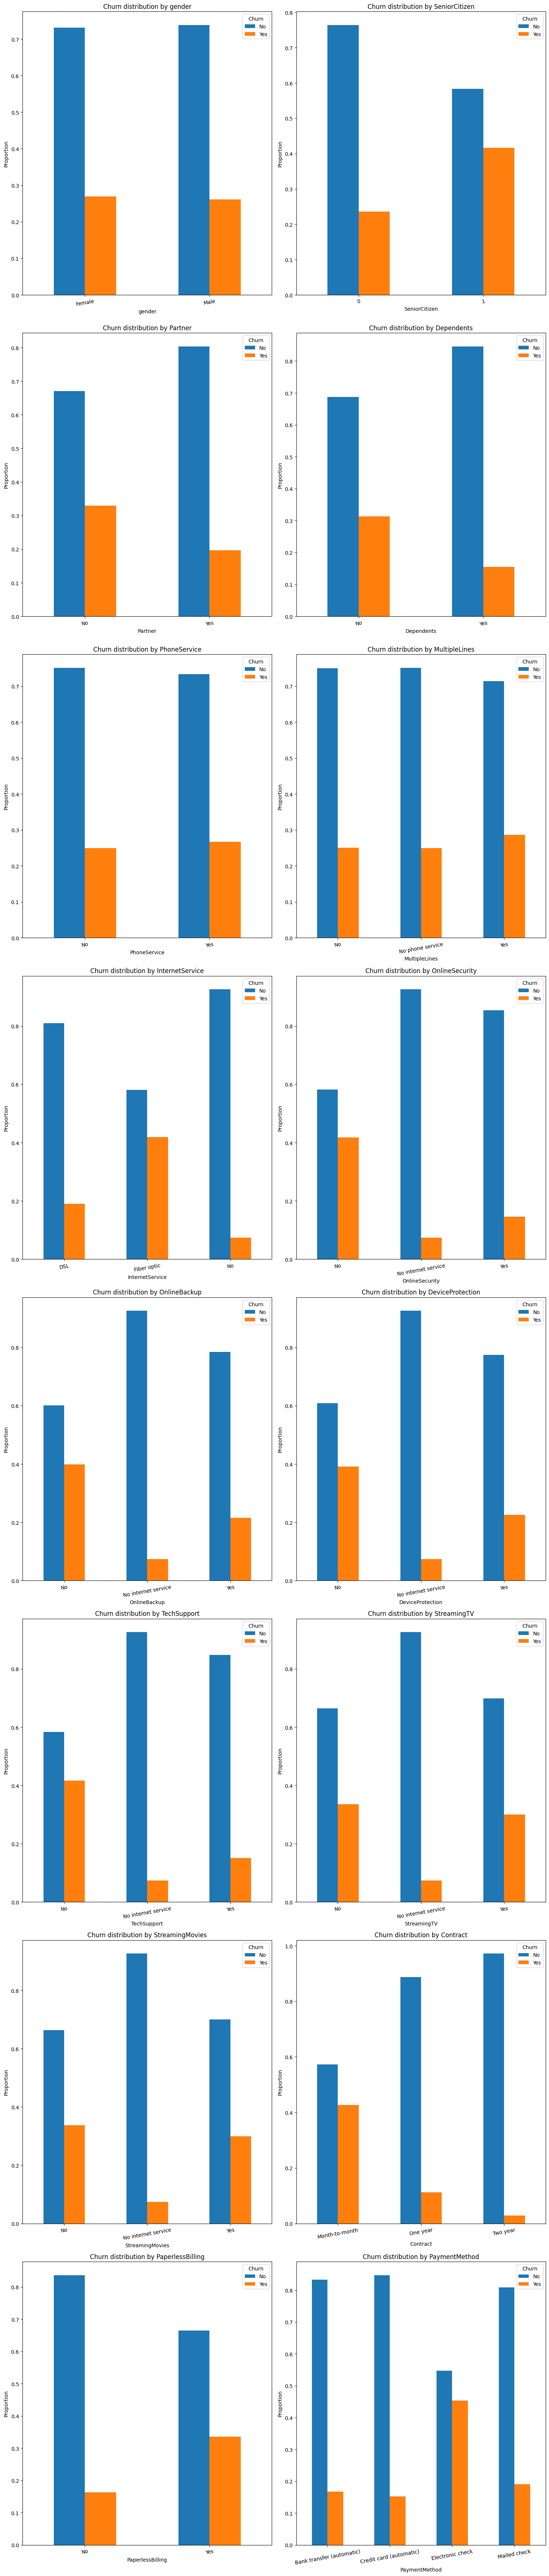

In [20]:
n_cols, n_rows = 2, 8

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 70))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    ct = pd.crosstab(churn_df[col], churn_df["Churn"], normalize="index")
    ct.plot(kind="bar", stacked=False, ax=axes[i])
    axes[i].set_title(f"Churn distribution by {col}")
    axes[i].set_ylabel("Proportion")
    axes[i].set_xlabel(col)
    axes[i].legend(title="Churn")
    axes[i].tick_params(axis="x", rotation=10)

plt.tight_layout()
plt.show()

Some observations

* Churn is (almost) evenly distributed for the variables gender.
* Senior citizen, people who have no partner and those who have not dependent are more likely to churn.
* On the services side, PhoneService and MultipleLines appear to have no impact on churn. In contrast, internet-related services (InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies) seem to play a particularly significant role in determining churn behavior.
* The contract-related features (Contract, PaperlessBilling, PaymentMethod) appear to be correlated with churn.

Finally, we will take a look at the distributions of churn for each numerical variable.

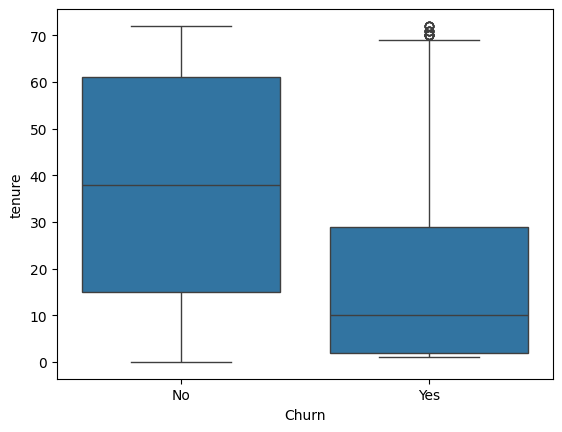

In [21]:
# Churn with tenure

sns.boxplot(data=churn_df, x="Churn", y="tenure")
plt.show()

By analyzing the two boxplots, we observe that customers who churn tend to have a shorter tenure with the company compared to those who remain. This seems logical in the sense that the more a person uses a service, the more difficult it will be for them to change it.

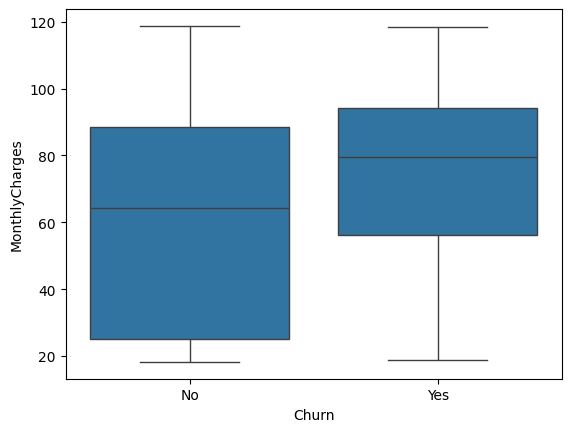

In [22]:
# Churn with MonthlyCharges

sns.boxplot(data=churn_df, x="Churn", y="MonthlyCharges")
plt.show()

Here, we can observe people who churn have a more significant monthly charges than the ones who don't.

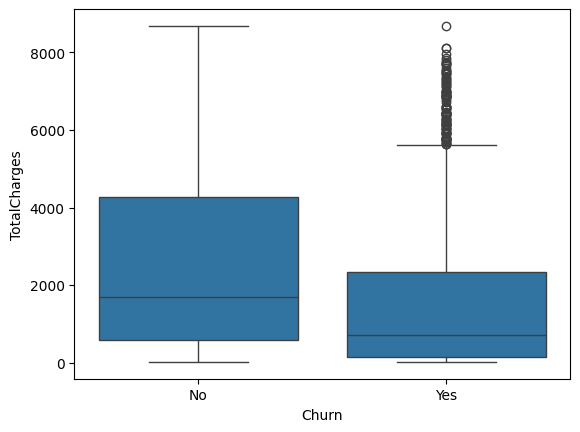

In [23]:
# Churn with TotalCharges

sns.boxplot(data=churn_df, x="Churn", y="TotalCharges")
plt.show()

Here, we can observice something that is normal. People who have important total charges are less likely to churn. In fact, the longer a customer stays with a company, the greater the total amount that customer will spend on various services.
The box of people who churned also shows an important number of outliers (based on the IQR rule).

#### **2.2.2. Correlation analysis**

Let's take a look the correlation between the numerical variables.

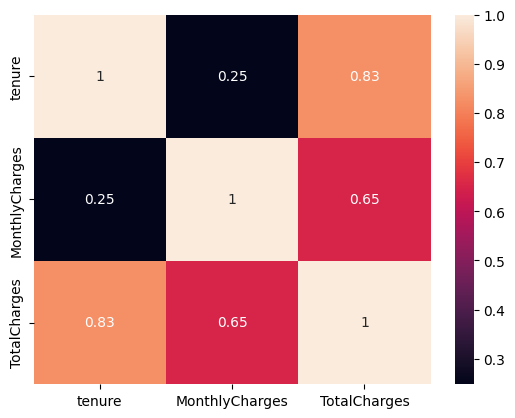

In [24]:
sns.heatmap(churn_df[numerical_cols].corr(), annot=True)
plt.show()

Tenure is strongly correlated to the total charges. This seems predictable in the sense that the longer a customer stays with a provider, the more they pay.

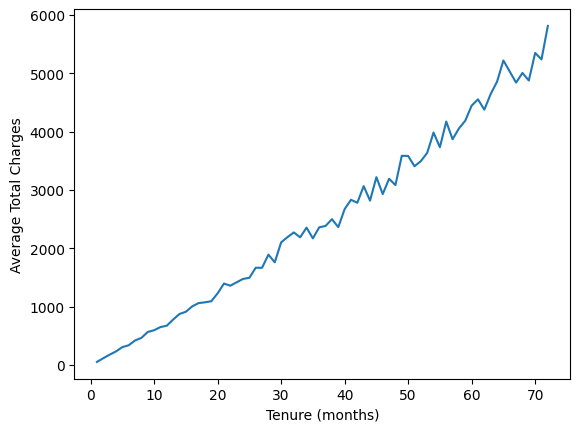

In [25]:
avg_charges = churn_df.groupby("tenure")["TotalCharges"].mean()
plt.plot(avg_charges.index, avg_charges.values)
plt.xlabel("Tenure (months)")
plt.ylabel("Average Total Charges")
plt.show()

The average total charges does indeed increase depending with the tenure.

<a id="data-cleaning"></a>

## **3. Data Cleaning**

Before the cleaning process, we will split our data in train and test sets.

In [26]:
y = churn_df["Churn"]
X = churn_df.drop(columns=["Churn"])

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### **3.1. Impute missing values**

In [28]:
X_train.isna().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        10
dtype: int64

We observed earlier than null total charges are related to customers who have a tenure equals to zero (the number of months of the contract is zero). For those customers, we will consider monthly charges as total charges.

In [29]:
mask_train = X_train["TotalCharges"].isna()
mask_test = X_test["TotalCharges"].isna()

X_train.loc[mask_train, "TotalCharges"] =  X_train.loc[mask_train, "MonthlyCharges"]
X_test.loc[mask_test, "TotalCharges"] =  X_test.loc[mask_test, "MonthlyCharges"]

### **3.2. Handle duplicate values**

In [30]:
X_train.duplicated().sum()

np.int64(24)

There are some duplicate values in the dataset. Let's drop them.

In [31]:
def drop_duplicates(X, y):
    # Mask to identify duplicates
    mask = X.duplicated(keep="first")
    # Retrieving the indexes of duplicates values
    idx = X[mask].index
    # Drop of the lines corresponding to thoses indexes in both X and y
    return X.drop(index=idx), y.drop(index=idx)

X_train, y_train = drop_duplicates(X_train, y_train)

Note that we did not remove duplicate values from the test set, as we treat it as a representation of real production data.

<a id="feature-selection"></a>

## **4. Feature Selection**

Some variables appear to be of little interest for predicting churn. These include the *gender* variable, the two variables related to telephone service (*PhoneService*, *MultipleLines*) and the two streaming variables (*StreamingMovies*, *StreamingTV*). Their distributions and their breakdown according to the Churn variable showed that they had very little impact on churn detection.

In [32]:
cat_to_drop = ["gender", "PhoneService", "MultipleLines", "StreamingMovies", "StreamingTV"]

for col in cat_to_drop:
    X_train = X_train.drop(columns=col)
    X_test = X_test.drop(columns=col)
    categorical_cols.remove(col)

<a id="feature-engineering"></a>

## **5. Feature Engineering**

### **5.1. Encode categorical variables**

In [33]:
cat_enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
X_train[categorical_cols] = cat_enc.fit_transform(X_train[categorical_cols])
X_test[categorical_cols] = cat_enc.transform(X_test[categorical_cols])

### **5.2. Encode the target variable**

In [34]:
t_enc = LabelEncoder()
y_train = t_enc.fit_transform(y_train)
y_test = t_enc.transform(y_test)

In [35]:
t_enc.classes_

array(['No', 'Yes'], dtype=object)

Here, we are sure "No" corresponds to 0 and "Yes" corresponds to 1 after the encoding.

### **5.3. Scale numerical variables**

In [36]:
scaler = MinMaxScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])

### **5.4. Oversampling the Training Set using SMOTE**

We will use SMOTE here to oversample the training set.

In [37]:
from imblearn.over_sampling import SMOTE

# Adjust the minority class so that its size reaches 70% of the majority class.
# Synthetic samples are generated using the three nearest neighbors of each minority instance.
smote = SMOTE(sampling_strategy=0.7, k_neighbors=3, random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

The final dataframe looks like this :

In [38]:
X_train.head().T

,0,1,2,3,4
SeniorCitizen,0.000000,0.000000,0.000000,0.000000,0.000000
Partner,0.000000,0.000000,1.000000,0.000000,0.000000
Dependents,1.000000,0.000000,0.000000,0.000000,1.000000
tenure,0.291667,0.750000,0.013889,0.055556,0.000000
InternetService,0.000000,0.500000,0.000000,0.500000,0.000000
OnlineSecurity,1.000000,0.000000,0.000000,0.000000,1.000000
OnlineBackup,0.000000,1.000000,0.000000,0.000000,1.000000
DeviceProtection,1.000000,0.000000,0.000000,0.000000,0.000000
TechSupport,0.000000,0.000000,0.000000,0.000000,1.000000
Contract,0.500000,1.000000,0.000000,0.000000,1.000000


<a id="modeling"></a>

## **6. Modeling**

### **6.1. Architecture and training**

We will use a Random Forest model.

In [39]:
param_grid = {
    "n_estimators": [100, 150, 200, 300],
    "max_depth": [2, 6, 10, 15, 20, None],
    "min_samples_split": [2, 4, 6, 10]
}

rf_model = RandomForestClassifier(criterion="gini", random_state=42)

# We prioritize maximizing recall to identify as many churned customers as possible, 
# even if it means some non-churned customers are misclassified.
rf_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring="recall", n_jobs=-1, cv=5)
rf_search.fit(X_train, y_train)

,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [2, 6, ...], 'min_samples_split': [2, 4, ...], 'n_estimators': [100, 150, ...]}"
,scoring,'recall'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,200


In [40]:
# Retrieving the best model
rf_final = rf_search.best_estimator_
rf_final

,n_estimators,200
,criterion,'gini'
,max_depth,15
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### **6.2. Evaluation**

In [41]:
y_test_pred = rf_final.predict(X_test)

print("Accuracy : ", accuracy_score(y_test, y_test_pred))
print("Precision : ", precision_score(y_test, y_test_pred))
print("Recall : ", recall_score(y_test, y_test_pred))
print("F1-Score : ", f1_score(y_test, y_test_pred))

Accuracy :  0.794180269694819
Precision :  0.6055979643765903
Recall :  0.6380697050938338
F1-Score :  0.6214099216710183


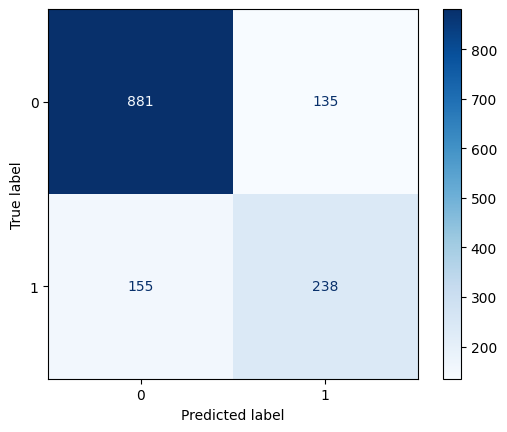

In [42]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test_pred, y_test))
disp.plot(cmap=plt.cm.Blues)
plt.show()

Let's take a look at the feature importance.

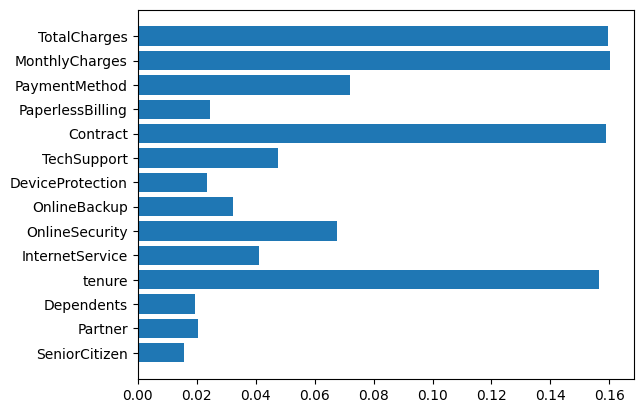

In [43]:
plt.barh(X_train.columns, rf_final.feature_importances_)
plt.show()

We can observe that the variables *TotalCharges*, *MonthlyCharges*, *Contract*, and *tenure* have the greatest impact on customer churn status.

<a id="conclusion"></a>

## **7. Conclusion**

If we cross-reference the importance of these characteristics with the analyses performed previously, we can deduce that **customers who have a month-to-month contract and customers who have a short tenure are more likely to churn**. **Human factors (gender, dependents, etc.) have very little impact on churn**. The next step would be to collect more data about customers and conduct a more in-depth investigation into the various services, especially those related to the internet.